In [29]:
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-03-10 08:11:06--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.110.221
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.110.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  35.5MB/s    in 9.7s    

2020-03-10 08:11:16 (33.4 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from fastai.vision import *

In [31]:
key_pts_frame = pd.read_csv('/data/training_frames_keypoints.csv')

n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [32]:
# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


In [0]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

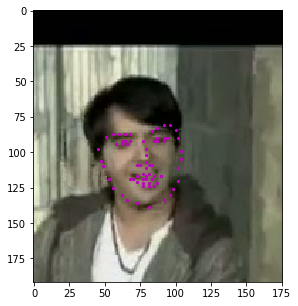

In [34]:
import os

n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('/data/training/', image_name)), key_pts)
plt.show()

In [0]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.c = 136

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)

        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].values
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample 

In [36]:
face_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                      root_dir='/data/training/')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


In [0]:
import torch
from torchvision import transforms, utils
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0


        return {'image': image_copy, 'keypoints': key_pts_copy}

In [0]:
import cv2 
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))

        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}

In [0]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


In [0]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

In [0]:
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)

In [0]:
batch_size = 16

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

In [0]:
import torchvision

model_conv = torchvision.models.resnet34(pretrained=True)

model_conv.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 136)


In [62]:
model_conv.cuda()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [63]:
x = next(iter(train_loader))
print(model_conv(x['image'].float().cuda()).shape)
print(x['keypoints'].reshape(x['keypoints'].shape[0],-1).shape)

torch.Size([16, 136])
torch.Size([16, 136])


In [0]:
from torch import nn
from torch import optim

loss_func = nn.MSELoss()
optimizer = optim.Adam(params = model.parameters(), lr = 0.001)

In [0]:
def train_net(n_epochs):

    # prepare the net for training
    model.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        # running_loss = 0.0
        for batch_i, data in enumerate(train_loader):

            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = model_conv(images.cuda())
            loss = loss_func(output_pts, key_pts.cuda())
  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print loss statistics
            # running_loss += loss.item()
            if batch_i % 100 == 99:    # print every 100 batches
                print(f'Epoch: {epoch + 1}, Batch: {batch_i+1}, Avg. Loss: {loss.item()}')
                running_loss = 0.0

    print('Finished Training')

In [66]:
n_epochs = 5
train_net(n_epochs)

Epoch: 1, Batch: 100, Avg. Loss: 0.9346420168876648
Epoch: 1, Batch: 200, Avg. Loss: 1.108983039855957
Epoch: 2, Batch: 100, Avg. Loss: 0.9923596978187561
Epoch: 3, Batch: 100, Avg. Loss: 0.923040509223938
Epoch: 3, Batch: 200, Avg. Loss: 0.9578399658203125
Epoch: 4, Batch: 100, Avg. Loss: 1.6718754768371582
Epoch: 4, Batch: 200, Avg. Loss: 1.1923621892929077
Epoch: 5, Batch: 100, Avg. Loss: 1.0993643999099731
Epoch: 5, Batch: 200, Avg. Loss: 1.0408122539520264
Finished Training
